In [ ]:
!git clone https://github.com/ChronoStellar/Automatic-License-Plate-Recognition

Cloning into 'Automatic-License-Plate-Recognition'...
remote: Enumerating objects: 14589, done.
remote: Counting objects: 100% (1322/1322), done.
remote: Compressing objects: 100% (1309/1309), done.
remote: Total 14589 (delta 8), reused 1322 (delta 8), pack-reused 13267 (from 1)
Receiving objects: 100% (14589/14589), 210.62 MiB | 13.92 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Updating files: 100% (14508/14508), done.


In [ ]:
# Install Libraries
!pip install -q transformers
!pip install -q evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Get Dataset
import os
# from google.colab import userdata

# os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
# os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# !kaggle datasets download -d firqaaa/indonesian-vehicle-plate-numbers --unzip --path /content/dataset

In [ ]:
# Process Dataset
PATH = '/content/Automatic-License-Plate-Recognition/dataset/segmentation'
images = []
labels = []

for filename in os.listdir(PATH):
  labels.append(filename.split('.')[0])
  images.append(os.path.join(PATH, filename))

images[:3], labels[:3]

(['/content/Automatic-License-Plate-Recognition/dataset/segmentation/H5856FZ.jpg',
  '/content/Automatic-License-Plate-Recognition/dataset/segmentation/H6823DK.jpg',
  '/content/Automatic-License-Plate-Recognition/dataset/segmentation/H2031EM.jpg'],
 ['H5856FZ', 'H6823DK', 'H2031EM'])

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

df = pd.DataFrame(zip(images, labels),columns=['file_name', 'text'])

df

file_name  \
0     /content/Automatic-License-Plate-Recognition/dataset/segmentation/H5856FZ.jpg   
1     /content/Automatic-License-Plate-Recognition/dataset/segmentation/H6823DK.jpg   
2     /content/Automatic-License-Plate-Recognition/dataset/segmentation/H2031EM.jpg   
3     /content/Automatic-License-Plate-Recognition/dataset/segmentation/H3590EK.jpg   
4     /content/Automatic-License-Plate-Recognition/dataset/segmentation/H5413II.jpg   
..                                                                              ...   
245  /content/Automatic-License-Plate-Recognition/dataset/segmentation/H6890AEC.jpg   
246   /content/Automatic-License-Plate-Recognition/dataset/segmentation/H6379DK.jpg   
247   /content/Automatic-License-Plate-Recognition/dataset/segmentation/H5529MI.jpg   
248  /content/Automatic-License-Plate-Recognition/dataset/segmentation/K3934AUC.jpg   
249  /content/Automatic-License-Plate-Recognition/dataset/segmentation/AD2025RU.jpg   

         text  
0     H5856FZ  
1     H6823DK  
2     H2031EM  
3     H3590EK  
4     H5413II  
..        ...  
245  H6890AEC  
246   H6379DK  
247   H5529MI  
248  K3934AUC  
249  AD2025RU  

[250 rows x 2 columns]

In [ ]:
# df.head()
path = df['file_name'].iloc[:1].to_string(index=False)
# path='/content/Automatic-License-Plate-Recognition/dataset/segmentation/H5856FZ.jpg'
print(f'{path}')

/content/Automatic-License-Plate-Recognition/dataset/segmentation/H5856FZ.jpg


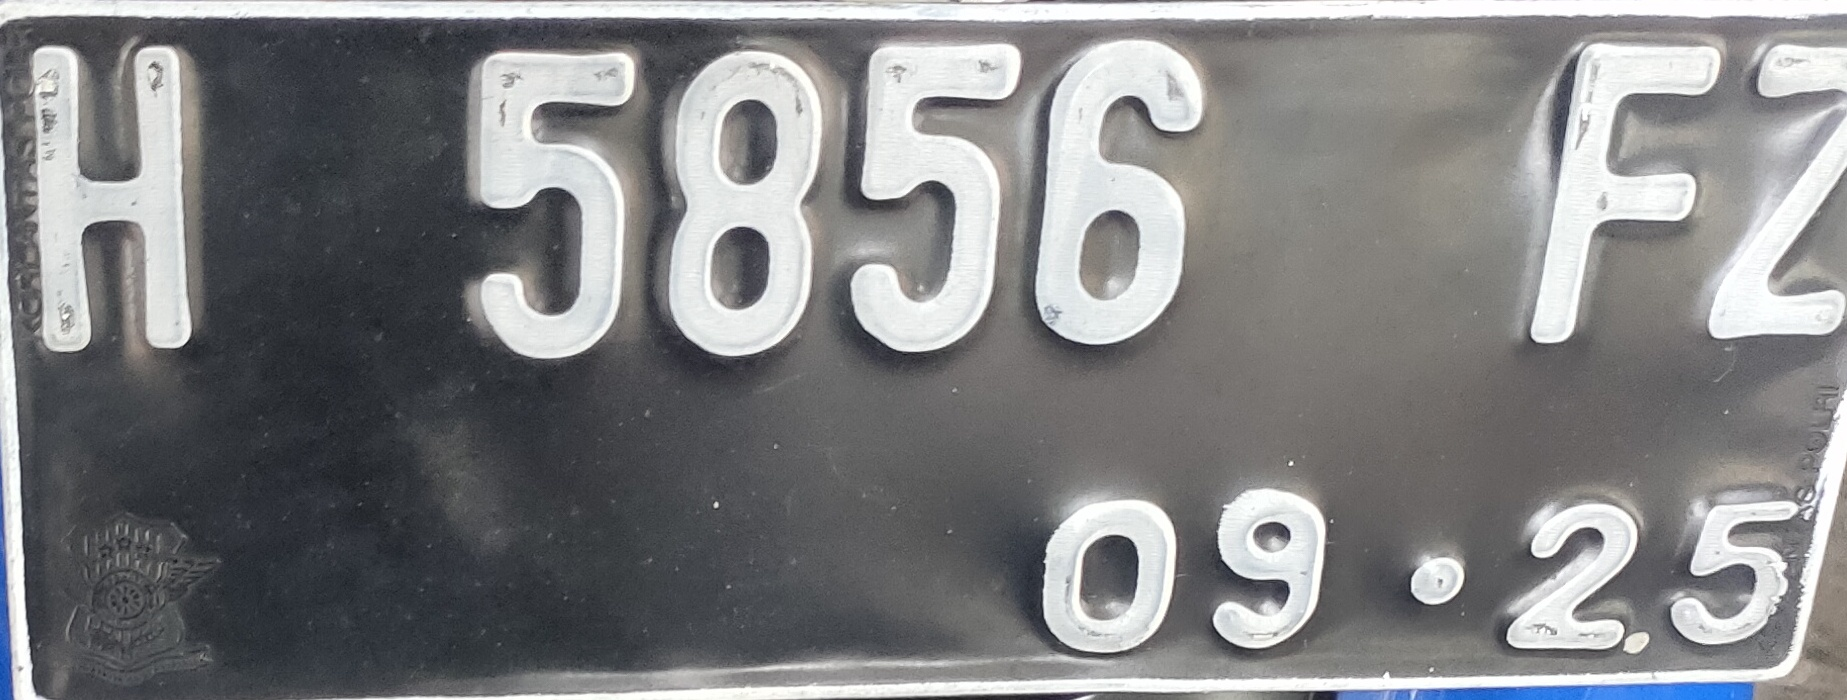

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow

img = cv.imread(path)
cv2_imshow(img)

In [ ]:
# Split Dataset
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

In [ ]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class createDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get file name and text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]

        # Prepare image (i.e., resize + normalize)
        image_path = os.path.join(self.root_dir, file_name)

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None  # or handle the error in another way

        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # Add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids

        # Important: ignore PAD tokens in loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.tensor(labels, dtype=torch.long)  # Ensure dtype consistency
        }

        return encoding


In [ ]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
import torch

# Load the model and processor
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare datasets
train_dataset = createDataset(root_dir=PATH, df=train_df, processor=processor)
eval_dataset = createDataset(root_dir=PATH, df=test_df, processor=processor)

# Optionally, check the dataset lengths
print(f"Training dataset size: {len(train_dataset)}")
print(f"Evaluation dataset size: {len(eval_dataset)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Training dataset size: 225
Evaluation dataset size: 25


In [ ]:
# Setup config trainer

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
# evalulation metrics
import evaluate

cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
# declare Seq2Seq trainer
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, TrainingArguments
# import wandb

# Initialize WandB project
# wandb.init(project="TrOCR_IndonesianLPR")

# Set training arguments with wandb integration
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=2,
    save_steps=1000,
    fp16=True,
    run_name="TrOCR_IndonesianLPR"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# train model
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator
    # add save to hugging face repo or mlflow
)
trainer.train()

trainer.save_model()  # Save locally
# trainer.save_tokenizer()

# trainer.push_to_hub(commit_message="Training complete, model saved.")  # Push to Hugging Face Hub


/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
<ipython-input-30-8ed1d71503be>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


AttributeError: 'Seq2SeqTrainer' object has no attribute 'save_tokenizer'

In [ ]:
from huggingface_hub import login

# Provide your Hugging Face API token directly (this can also be stored as an environment variable)
login()

In [ ]:
trainer.push_to_hub(commit_message="Training complete, model saved.")  # Push to Hugging Face Hub

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

events.out.tfevents.1733033329.5ee40c9d40be.182.0:   0%|          | 0.00/24.7k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ChronoStellar/results/commit/03b4f549d64d16463111c9387662a12af216c28a', commit_message='Training complete, model saved.', commit_description='', oid='03b4f549d64d16463111c9387662a12af216c28a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ChronoStellar/results', endpoint='https://huggingface.co', repo_type='model', repo_id='ChronoStellar/results'), pr_revision=None, pr_num=None)

In [ ]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
import torch
from PIL import Image

# Load the fine-tuned model
model_path = "/content/results/checkpoint-145"
model = VisionEncoderDecoderModel.from_pretrained(model_path)
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")

# Move model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linea

# Evaluate

In [ ]:
# Process Dataset
PATH = '/content/Automatic-License-Plate-Recognition/dataset/test'
images = []
labels = []

for filename in os.listdir(PATH):
  labels.append(filename.split('.')[0])
  images.append(os.path.join(PATH, filename))

labels[:3], images[:3]

(['E2118ST', 'E4538QK', 'B8837NR'],
 ['/content/Automatic-License-Plate-Recognition/dataset/test/E2118ST.jpg',
  '/content/Automatic-License-Plate-Recognition/dataset/test/E4538QK.jpg',
  '/content/Automatic-License-Plate-Recognition/dataset/test/B8837NR.jpg'])

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def OCR(image_path, model=model, processor=processor, device=device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")

    # Prepare image for the model
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # Move the input to the appropriate device (CPU/GPU)
    pixel_values = pixel_values.to(device)

    # Generate prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        generated_ids = model.generate(pixel_values)

    # Decode the predicted IDs to get the text
    predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # print(f"Predicted Text: {predicted_text}")

    # Add the label to the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()  # Load a default font, you can customize this

    # Define the position for the text label
    text_position = (10, 10)

    # Draw the predicted text on the image
    draw.text(text_position, predicted_text, font=font, fill=(255, 0, 0))  # Red text

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')  # Turn off axes for better visualization
    plt.show()

    return predicted_text

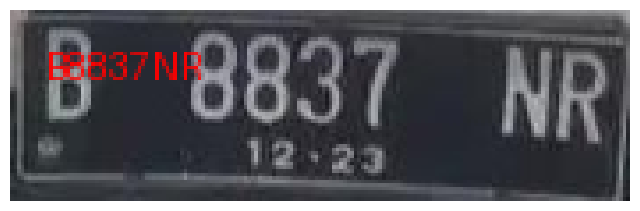

'B8837NR'

In [ ]:
OCR('/content/Automatic-License-Plate-Recognition/dataset/test/B8837NR.jpg')

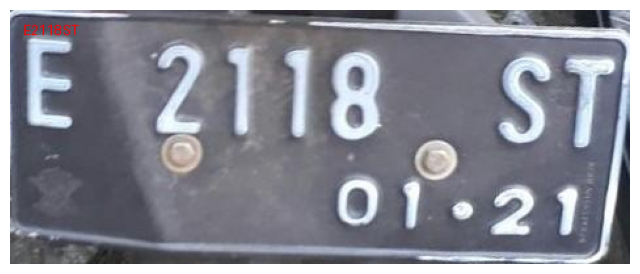

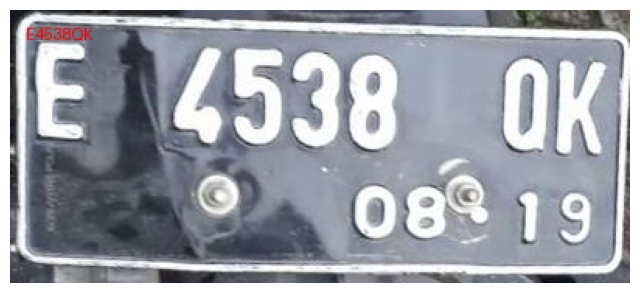

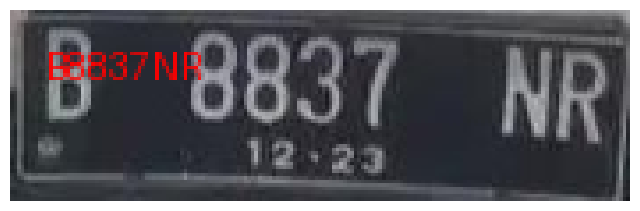

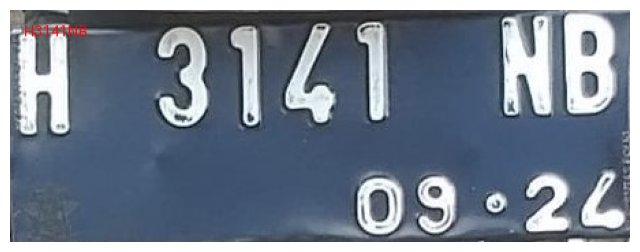

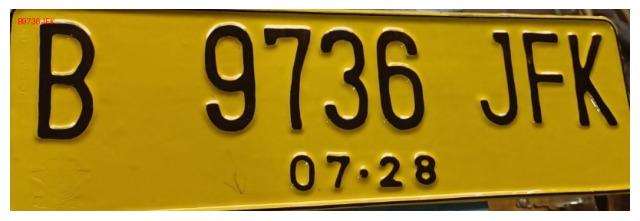

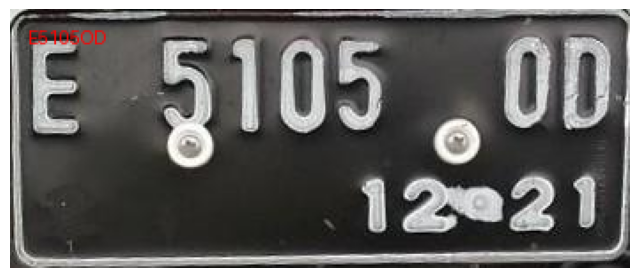

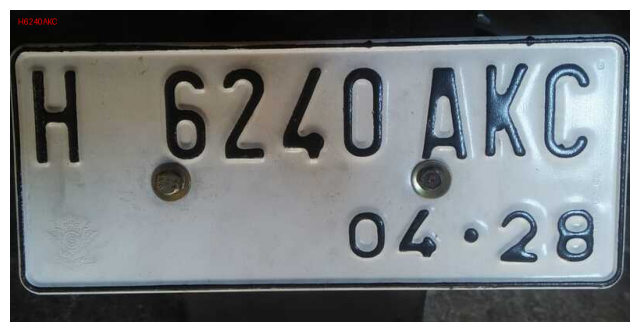

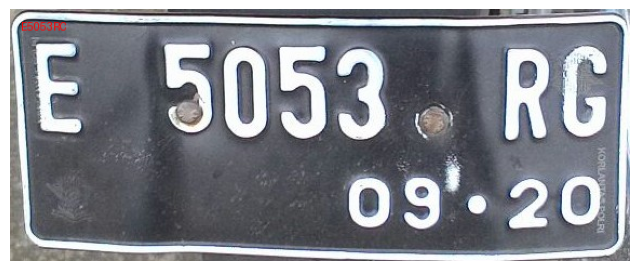

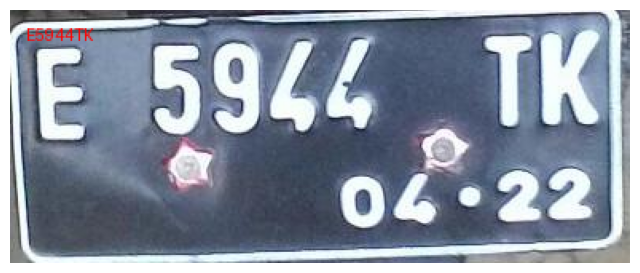

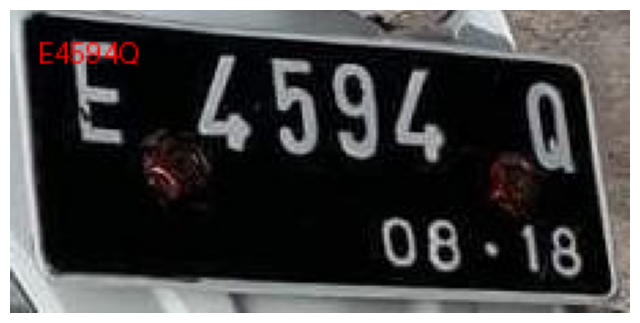

10

In [ ]:
result = []
for i in images:
  result.append(OCR(i))
len(result)

In [ ]:
import evaluate
wer = evaluate.load('wer')
cer = evaluate.load('cer')

In [ ]:
word_accuracy = wer.compute(references=labels, predictions=result)
character_accuracy = cer.compute(references=labels, predictions=result)

print(f'wer: {word_accuracy}, cer: {character_accuracy}')

wer: 0.1, cer: 0.014084507042253521


In [ ]:
for i,x in enumerate(zip(result, labels)):
  print(i,x)

0 ('E2118ST', 'E2118ST')
1 ('E4538QK', 'E4538QK')
2 ('B8837NR', 'B8837NR')
3 ('H3141NB', 'H3141NB')
4 ('B9736JFK', 'B9736JFK')
5 ('E5105OD', 'E5105OD')
6 ('H6240AKC', 'H6240AKC')
7 ('E5053RC', 'E5053RG')
8 ('E5944TK', 'E5944TK')
9 ('E4594Q', 'E4594Q')
